In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=1.5
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk
from omfit_classes.omfit_eqdsk import boundaryShape

In [3]:
mygs = TokaMaker()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          aba6d8f
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



In [4]:
#mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('nextstep_mesh.h5')
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('nextstep_mesh_0805.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order=2,F0=1*3)



**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.914E+00
    # of points  =    6901
    # of edges   =   20584
    # of cells   =   13684
    # of boundary points =     116
    # of boundary edges  =     116
    # of boundary cells  =     116
  Resolution statistics:
    hmin =  1.244E-03
    hrms =  3.068E-02
    hmax =  1.118E-01
  Surface grounded at vertex    1129


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    2.3149999999999998E-003


In [5]:
delta = -0.5
fix_xloc = False  #maintains location of x-points when changing triangularity by modifying inner/outer midplane gaps

In [6]:
coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
targets = np.zeros(mygs.ncoils+1)
coil_weights = 0.5*np.ones(mygs.ncoils+1)

#Constrain CS current
coil_reg_mat[0,0] = 1
coil_reg_mat[1,1] = 1
coil_reg_mat[1,0] = -1
coil_reg_mat[2,2] = 1
coil_reg_mat[2,1] = -1

targets[0] = -3E6

coil_weights[:3] = 5

#Enforce up/down symmetry in PF coils
coil_reg_mat[3,3] = 1
coil_reg_mat[3,7] = -1
coil_reg_mat[4,4] = 1
coil_reg_mat[4,8] = -1
coil_reg_mat[5,5] = 1
coil_reg_mat[5,9] = -1
coil_reg_mat[6,6] = 1
coil_reg_mat[6,10] = -1

mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

In [7]:
#Set upper bound on coil currents
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11

#turn off div coils, for now
#coil_bounds[-5:-1, 0] = -122448.979592
#coil_bounds[-5:-1, 1] = 122448.979592
coil_bounds[-3:-1, 0] = 0 
coil_bounds[-3:-1, 1] = 0

mygs.set_coil_bounds(coil_bounds)

In [8]:
# Define shape of P' anf FF' profiles
n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)
# Set F*F' profile
alpha = 2
gamma = 1.25

ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
# Set P' profile
alpha = 2
gamma = 1.25
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

In [9]:
# set global targets
Ip_target = 0.75E6
mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

In [10]:
# set boundary/saddle point/strike point targets
if fix_xloc:
    d0 = -0.5
    if delta<d0:
        boundary = create_isoflux(4,1+0.2588*((1-d0)/(1-delta)-1),0.0,0.2588*(1-d0)/(1-delta),1.7*(1-delta)/(1-d0),delta)
    else:
        boundary = create_isoflux(4,1+0.2588*(1-(1+d0)/(1+delta)),0.0,0.2588*(1+d0)/(1+delta),1.7*(1+delta)/(1+d0),delta)
else:
    boundary = create_isoflux(4,1,0.0,0.2588,1.7,delta)
    r, z, zeff = boundaryShape(kapu = 1.7, kapl = 1.7, delu = delta, dell = delta, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/1, zoffset = 0, upnull = True, lonull = True, npts = 8)
    boundary = np.column_stack((r,z))
    boundary = np.nan_to_num(boundary)



x_points = np.zeros((2,2))
x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
x_weights = 50*np.ones(2)
mygs.set_saddles(x_points, x_weights)

strike_ul = [1.06, 0.55]
strike_ur = [1.255, 0.495]

strike_ll = np.copy(strike_ul)
strike_ll[1] = -strike_ul[1]
strike_lr = np.copy(strike_ur)
strike_lr[1] = -strike_ur[1]

#boundary = np.vstack((boundary, strike_ul, strike_ll, strike_lr, strike_ur))
isoflux_weights = 50*np.ones(len(boundary))
#isoflux_weights[-4:] = 500

mygs.set_isoflux(boundary, isoflux_weights)

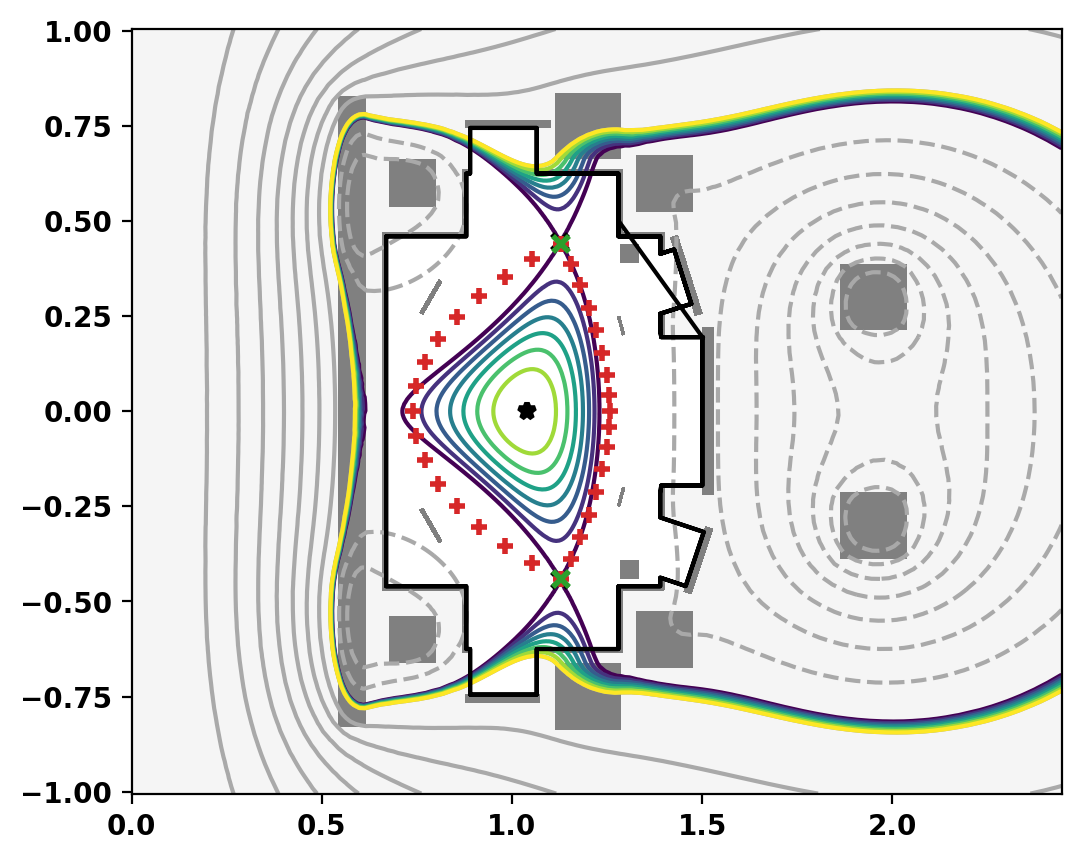

In [11]:
mygs.init_psi(1,0,0.25, 1.7,-0.5)
fig, ax = plt.subplots()
mygs.plot_psi(fig,ax)
mygs.plot_machine(fig,ax)
mygs.plot_constraints(fig,ax)

In [12]:
mygs.init_psi(1,0,0.25, 1.7,-0.5)
mygs.settings.maxits = 100
mygs.update_settings()
mygs.solve()

Starting non-linear GS solver
     1  7.1248E+00  3.3508E+00  1.5364E-02  1.0398E+00 -8.8004E-05 -0.0000E+00
     2  6.3202E+00  3.0020E+00  3.2779E-03  1.0388E+00 -6.8546E-05 -0.0000E+00
     3  6.1102E+00  2.9137E+00  6.0654E-04  1.0381E+00 -5.6036E-05 -0.0000E+00
     4  6.0312E+00  2.8806E+00  4.3880E-04  1.0377E+00 -4.8858E-05 -0.0000E+00
     5  5.9998E+00  2.8674E+00  2.7763E-04  1.0375E+00 -4.5185E-05 -0.0000E+00
     6  5.9872E+00  2.8621E+00  1.4827E-04  1.0374E+00 -4.3366E-05 -0.0000E+00
     7  5.9822E+00  2.8600E+00  7.2733E-05  1.0374E+00 -4.2483E-05 -0.0000E+00
     8  5.9803E+00  2.8591E+00  3.3915E-05  1.0374E+00 -4.2057E-05 -0.0000E+00
     9  5.9795E+00  2.8588E+00  1.5279E-05  1.0374E+00 -4.1850E-05 -0.0000E+00
    10  5.9792E+00  2.8587E+00  6.7088E-06  1.0374E+00 -4.1750E-05 -0.0000E+00
    11  5.9791E+00  2.8586E+00  2.8859E-06  1.0374E+00 -4.1702E-05 -0.0000E+00
    12  5.9790E+00  2.8586E+00  1.2202E-06  1.0374E+00 -4.1679E-05 -0.0000E+00
    13  5.9790E+00  2.

0

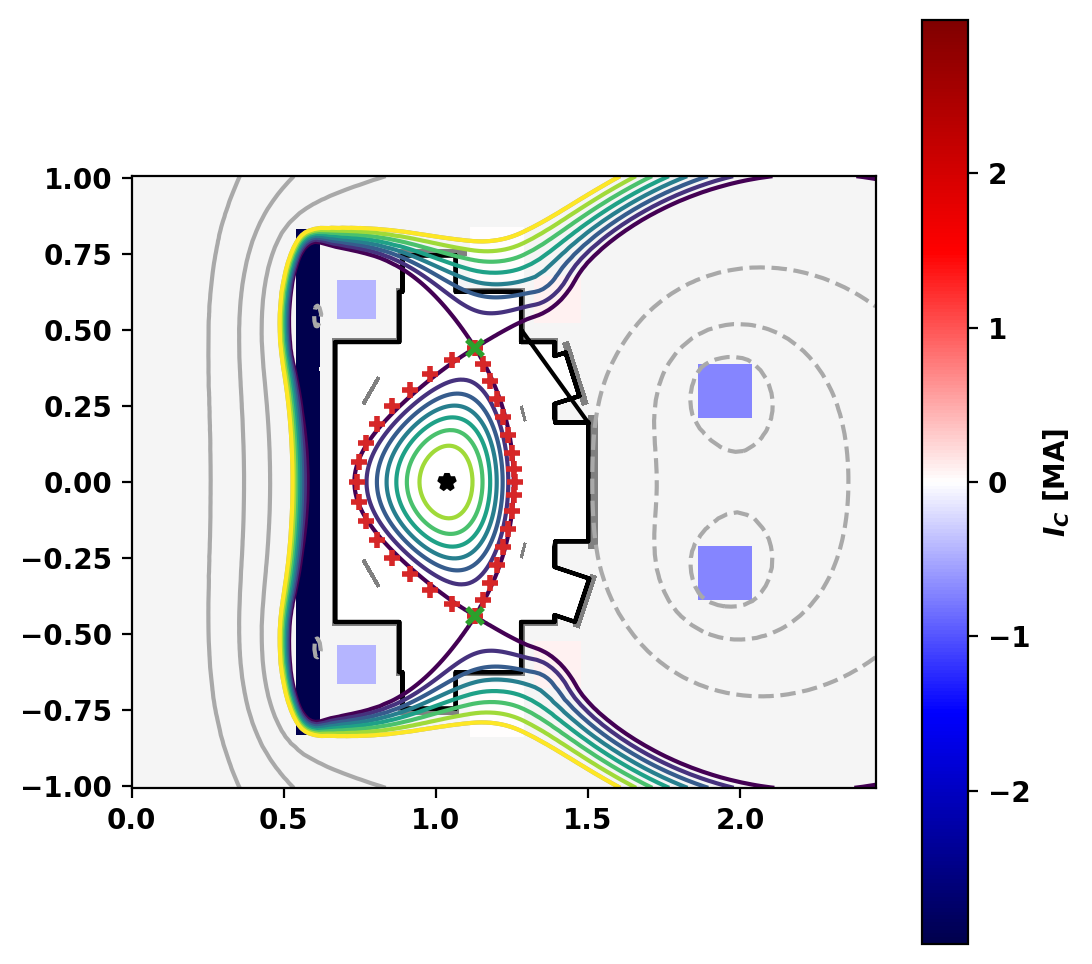

In [13]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
mygs.plot_constraints(fig,ax)




In [14]:
mygs.save_eqdsk('nextstep_gfile', lcfs_pad = 0.0000001, nr = 300, nz = 300)

Saving EQDSK file
 "none"


In [32]:
from omfit_classes.omfit_eqdsk import OMFITgeqdsk
eq  = OMFITgeqdsk('nextstep_gfile')
geo = eq['fluxSurfaces']['geo']
#print(eq['fluxSurfaces']['geo']['cxArea'][-1]**2/(np.pi*eq['fluxSurfaces']['geo']['a'][-1]**2))


Flux surfaces from 300x300 gEQDSK
Levels based on psi ...
Grid diagonal resolution: 0.00628321386000523 [m]
Cropping tables ...
Find magnetic axis ...
Find separatrix ...
Tracing flux surfaces ...
  > Took 0:00:00.367795
Find Br, Bz, F on flux surfaces ...
  > Took 0:00:00.242045
Flux surface averaging ...
  > Took 0:00:00.353468
Geometric quantities ...
  > Took 0:00:01.112408


300
300


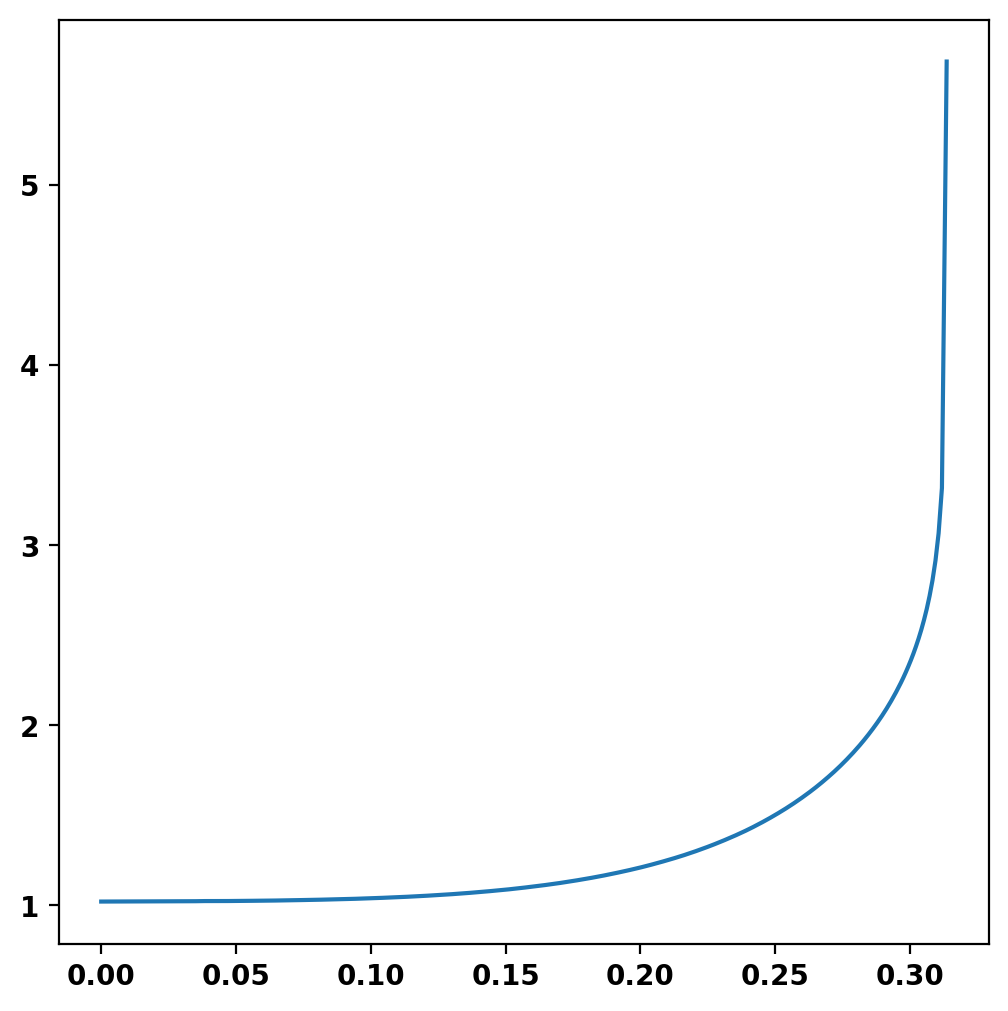

In [58]:
print(len(geo['rho']))
print(len(eq['QPSI']))
plt.plot(geo['rho'], eq['QPSI'])


In [39]:
print(geo['cxArea'][-1])
print(np.pi*geo['a'][-1]**2)
print(geo['cxArea'][-1]/(np.pi*geo['a'][-1]**2))
print(geo['kap'][-1]/(geo['cxArea'][-1]/(np.pi*geo['a'][-1]**2)))

0.2990694976605316
0.21543419267811081
1.3882174131354523
1.206341483247301


In [50]:
ind = np.floor(0.95*len(geo['kap']))
ind
print(geo['kap'][int(ind)])
print(geo['cxArea'][-1]/(np.pi*geo['a'][-1]**2)/geo['kap'][int(ind)])
print(geo['delta'][-1]/geo['delta'][int(ind)])

1.5127352079106409
0.9176869857169716
1.2420171241546956


In [15]:
mygs.print_info()

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    7.5000E+05
  Current Centroid [m]    =    1.028 -0.000
  Magnetic Axis [m]       =    1.037 -0.000
  Elongation              =    1.643 (U:  1.698, L:  1.589)
  Triangularity           =   -0.488 (U: -0.515, L: -0.461)
  Plasma Volume [m^3]     =    1.924
  q_0, q_95               =    1.025  2.266
  Peak Pressure [Pa]      =    1.4720E+05
  Stored Energy [J]       =    1.2347E+05
  <Beta_pol> [%]          =   51.8625
  <Beta_tor> [%]          =    1.2624
  Diamagnetic flux [Wb]   =    5.4066E-03
  Toroidal flux [Wb]      =    8.9138E-01
  l_i                     =    0.9399


Starting CG solver
     0  0.000000E+00  0.000000E+00  1.573863E+00
     1 -9.879255E+04  4.300105E+05  3.597544E-01  8.366178E-07
     2 -1.038677E+05  4.845731E+05  1.808004E-01  3.731129E-07
     3 -1.045313E+05  5.025546E+05  6.106285E-02  1.215049E-07
     4 -1.045579E+05  5.037834E+05  2.621615E-02  5.203853E-08
     5 -1.045610E+05  5.036569E+05  1.129291E-02  2.242182E-08
     6 -1.045616E+05  5.036060E+05  4.422689E-03  8.782042E-09
     7 -1.045617E+05  5.035550E+05  1.500988E-03  2.980784E-09
     8 -1.045617E+05  5.035557E+05  5.383895E-04  1.069176E-09
     9 -1.045617E+05  5.035557E+05  2.284888E-04  4.537508E-10
    10 -1.045617E+05  5.035577E+05  1.014843E-04  2.015347E-10
    20 -1.045617E+05  5.035578E+05  7.067541E-09  1.403521E-14
Growth rate = 3.8420E+02 [s^-1]
Growth time = 2.6028E-03 [s]


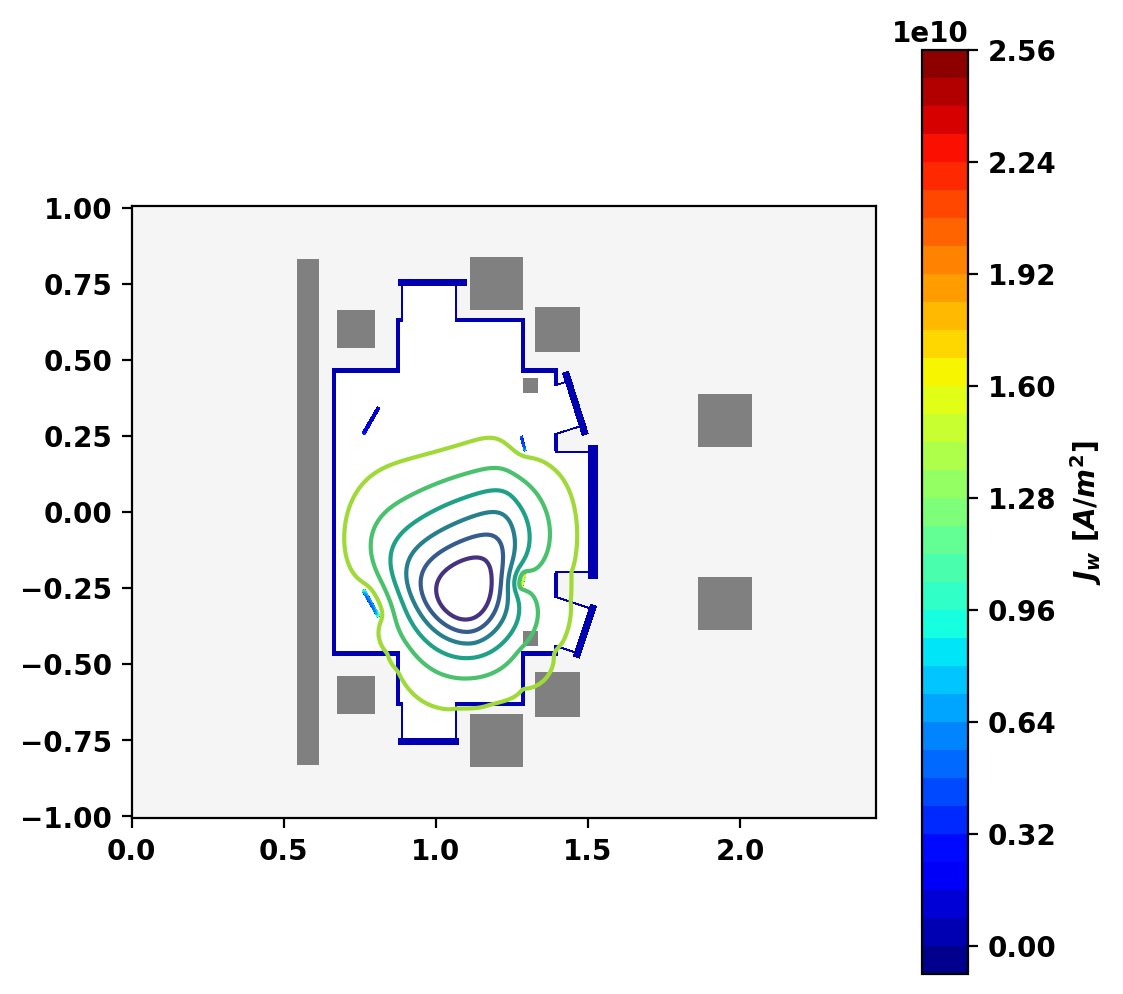

In [16]:
eig_vals, eig_vecs = mygs.eig_td(-5.E4,10,True) 
fig, ax = plt.subplots()
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,eig_vecs[0,:],normalized=False,xpoint_color=None,opoint_color=None)
mygs.plot_eddy(fig,ax,-eig_vecs[0,:]*eig_vals[0,0])
print('Growth rate = {0:.4E} [s^-1]'.format(-eig_vals[0,0]))
print('Growth time = {0:.4E} [s]'.format(-1.0/eig_vals[0,0]))

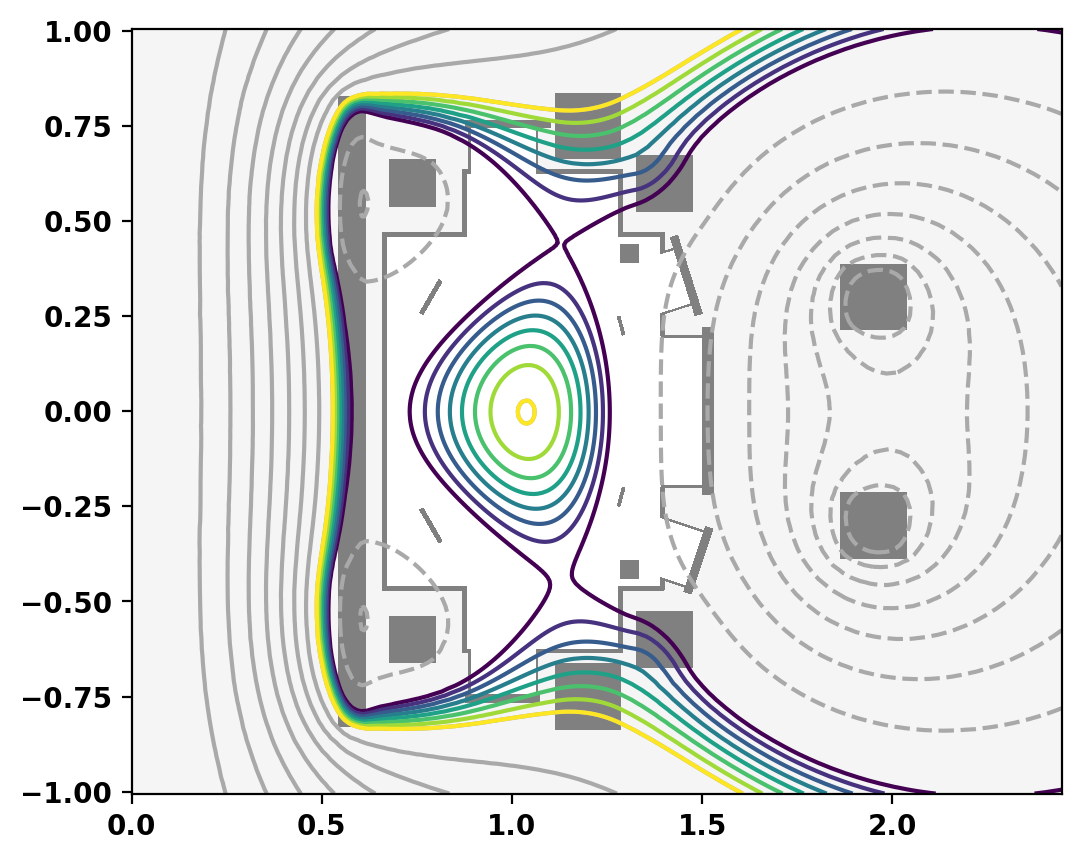

In [17]:
psi0 = mygs.get_psi(normalized = False)
max_loc = abs(eig_vecs[0,:]).argmax()
psi_ic = psi0+eig_vecs[0,:]*(mygs.psi_bounds[1]-mygs.psi_bounds[0])/eig_vecs[0,max_loc]/50

fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,(psi_ic-mygs.psi_bounds[1])/(mygs.psi_bounds[0]-mygs.psi_bounds[1]),xpoint_color=None,opoint_color=None)
mygs.set_psi(psi_ic)

In [18]:
mygs.settings.pm=False
mygs.update_settings()
mygs.set_isoflux(None)
mygs.set_targets(Ip=0.75E6,Ip_ratio=1)
mygs.setup_td(1.E-04,1.E-13,1.E-11,pre_plasma=False)

In [19]:
import time
sim_time = 0.0
dt = 1.E-1/-eig_vals[0,0]
nplot = 1
nstatus = 1
results = [mygs.get_psi()]
results_raw = [mygs.get_psi(False)]
z0 = [[sim_time,mygs.o_point[1]],]
eig_comp = [[sim_time,np.dot(eig_vecs[0,:],mygs.get_psi(normalized=False)-psi0)],]
t00 = time.perf_counter()
q_95 = []
gammas = []

for i in range(82):
    t0 = time.perf_counter()
    sim_time, _, nl_its, lin_its, nretry = mygs.step_td(sim_time,dt)
    t1 = time.perf_counter()
    if i % nstatus == 0:
        print('{0:.5E} {1:.5E} {2:4d} {3:4d} {5:8.3f} {4:4d}'.format(sim_time,dt,nl_its,lin_its,nretry,t1-t0))
    z0.append([sim_time,mygs.o_point[1]])
    eig_comp.append([sim_time,np.dot(eig_vecs[0,:],mygs.get_psi(normalized=False)-psi0)])
    q_prof = mygs.get_q()
    if i % nplot == 0:
        results.append(mygs.get_psi())
        results_raw.append(mygs.get_psi(False))
        psi,qvals,ravgs,dl,rbounds,zbounds = mygs.get_q(psi = 0.95)
        eig_vals, eig_vecs = mygs.eig_td(-5.E3,3,True) 
        gammas.append(-eig_vals[0,0])
        q_95.append(qvals[0])
t1 = time.perf_counter()
print('Total time = {0:8.3f}'.format(t1-t00))

2.60279E-04 2.60279E-04    2   17    0.425    0
5.20558E-04 2.60279E-04    2   14    0.232    0
7.80838E-04 2.60279E-04    2   14    0.232    0
1.04112E-03 2.60279E-04    2   14    0.813    0
1.30140E-03 2.60279E-04    2   15    0.421    0
1.56168E-03 2.60279E-04    2   15    0.995    0


KeyboardInterrupt: 

Text(0, 0.5, '$\\mathrm{q}_{95}$')

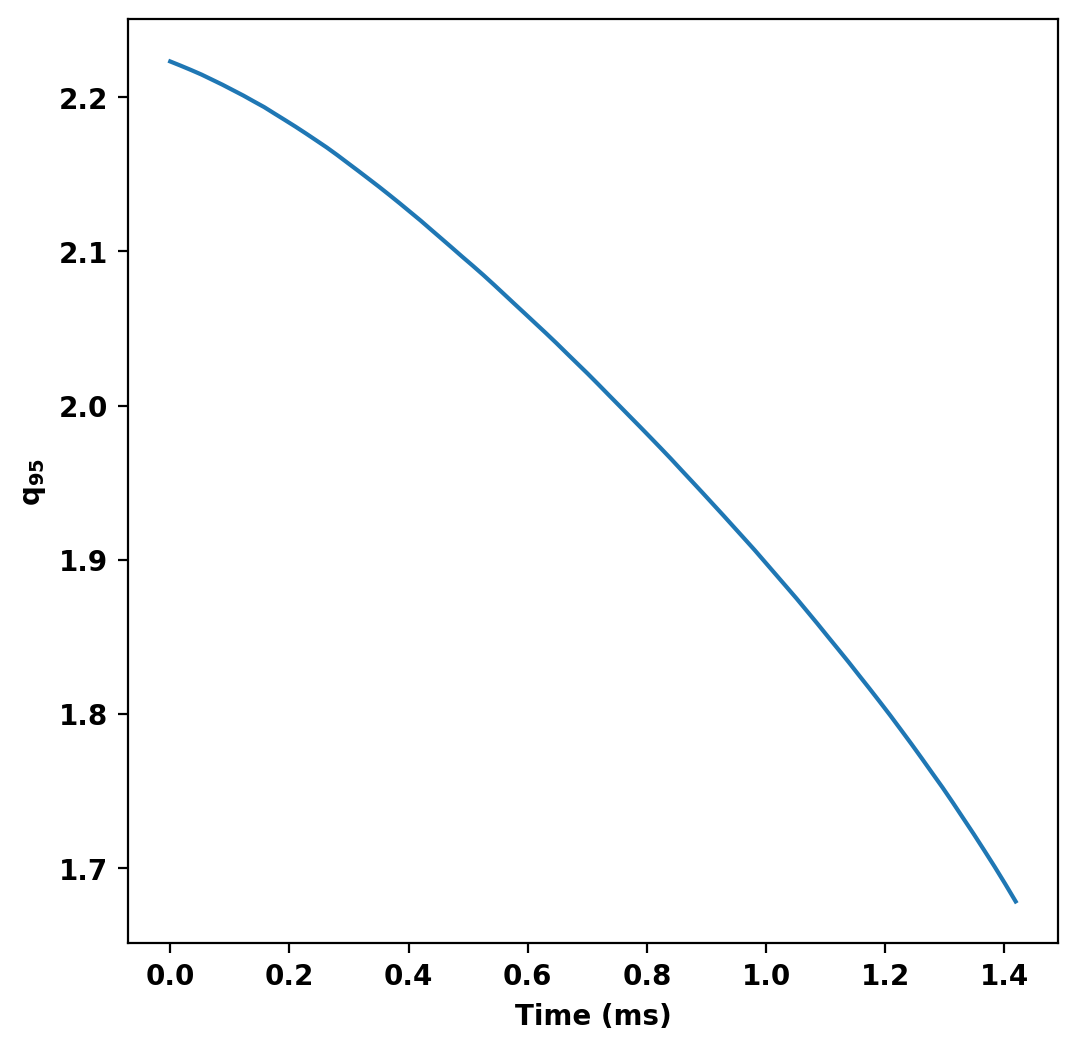

In [ ]:
plt.plot(np.linspace(0,sim_time*1000, len(q_95)), q_95)
plt.xlabel('Time (ms)')
plt.ylabel(r'$\mathrm{q}_{95}$')

Text(0, 0.5, '$\\gamma$ ($\\mathrm{s}^{-1}$)')

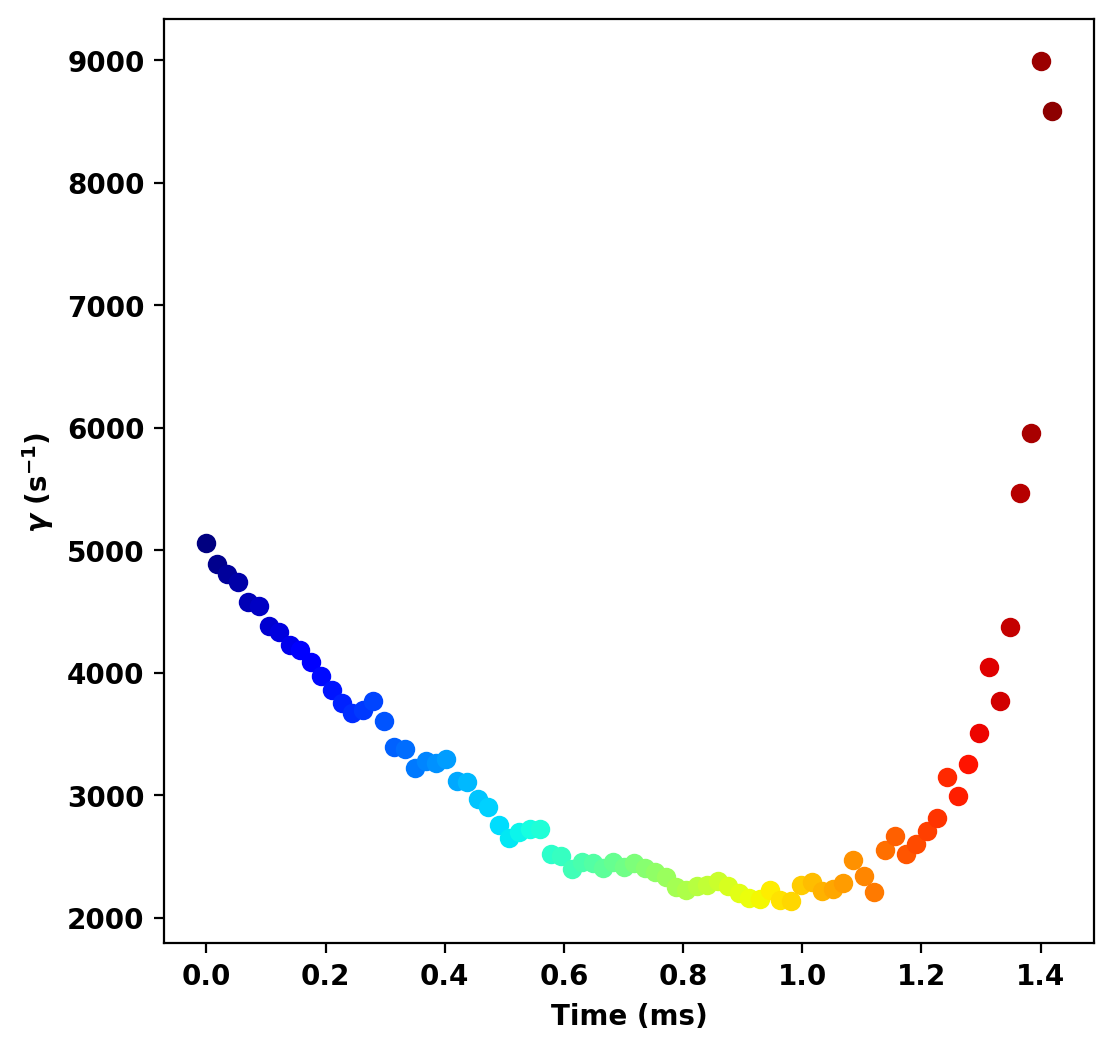

In [ ]:
colors = plt.cm.jet(np.linspace(0,1,len(results)))
for i in range(len(gammas)):
    plt.scatter(np.linspace(0,sim_time*1000, len(gammas))[i],gammas[i], color = colors[i])
plt.xlabel('Time (ms)')
plt.ylabel(r'$\gamma$ ($\mathrm{s}^{-1}$)')

Text(0, 0.5, 'Z (m)')

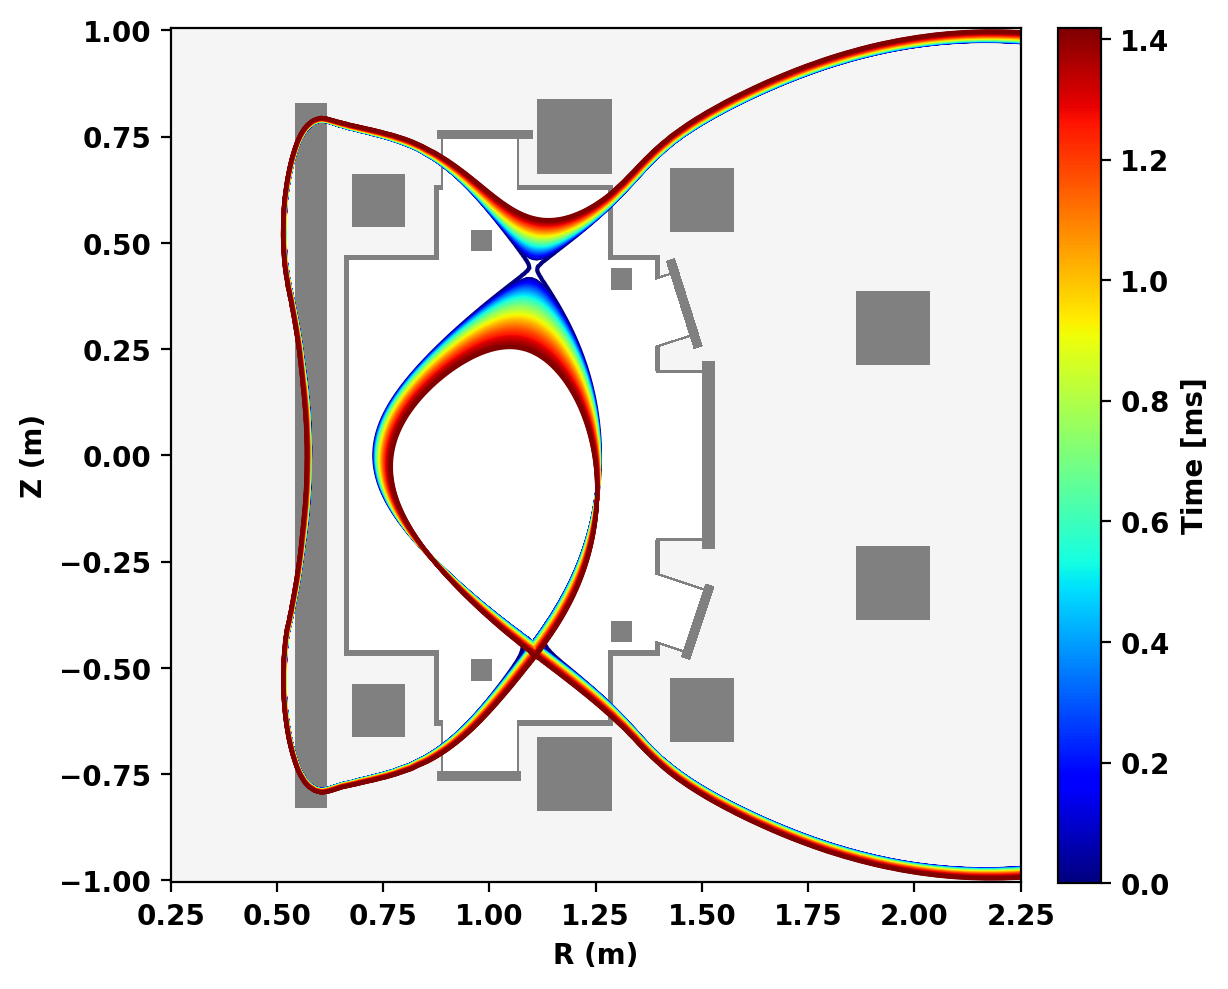

In [ ]:
import matplotlib as mpl
fig, ax = plt.subplots()
mygs.plot_machine(fig,ax, limiter_color = None)
colors = plt.cm.jet(np.linspace(0,1,len(results)))
for i, result in enumerate(results):
    mygs.plot_psi(fig,ax,psi=result,plasma_nlevels=1,plasma_color=[colors[i]], vacuum_nlevels = 0,xpoint_color=None,opoint_color=None)
norm = mpl.colors.Normalize(vmin=0.0, vmax=sim_time*1.E3)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet), ax = ax,label='Time [ms]',fraction=0.046, pad=0.04)
plt.xlim([0.25, 2.25])
plt.xlabel('R (m)')
plt.ylabel('Z (m)')